# **SML TEAM**
## **Notes**
```
Requirements: 
* comet_ml, pip install comet_ml
* tensorflow (tested 1.13.1)
* scikit-learn
* pandas
* h5py
```

### 1. Submission 01  
- Overall Mean Square Error: **0.078661**  
- Mean Square Error for Engagement level 0: 0.334221  
- Mean Square Error for Engagement level 1: 0.083368  
- Mean Square Error for Engagement level 2: 0.013338  
- Mean Square Error for Engagement level 3: 0.066046

### 2. Submission 02
- Overall Mean Square Error: **0.091114** 
- Mean Square Error for Engagement level 0: 0.328931 
- Mean Square Error for Engagement level 1: 0.108693 
- Mean Square Error for Engagement level 2: 0.027030 
- Mean Square Error for Engagement level 3: 0.035344

### 3. Submission 03
- Overall Mean Square Error: **0.069625** 
- Mean Square Error for Engagement level 0: 0.268581 
- Mean Square Error for Engagement level 1: 0.064421 
- Mean Square Error for Engagement level 2: 0.023098 
- Mean Square Error for Engagement level 3: 0.064037 

### 4. Submission 04  
- Overall Mean Square Error: **0.062841** 
- Mean Square Error for Engagement level 0: 0.220366 
- Mean Square Error for Engagement level 1: 0.040467 
- Mean Square Error for Engagement level 2: 0.031986 
- Mean Square Error for Engagement level 3: 0.102218 

### 5. Submission 05
- Overall Mean Square Error: **0.059678** 
- Mean Square Error for Engagement level 0: 0.246069 
- Mean Square Error for Engagement level 1: 0.029697 
- Mean Square Error for Engagement level 2: 0.022397 
- Mean Square Error for Engagement level 3: 0.137770 

In [1]:
import comet_ml
from utils import EngagementDataset
import md_config as cfg
import os, time, glob
import shutil

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import random
import joblib

seed = 0
np.random.seed(seed)
random.seed(0)

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
session = tf.Session(config=config)

tf.set_random_seed(seed)

import copy
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM, Dense, TimeDistributed, GlobalAveragePooling1D, Activation, Concatenate, \
    InputLayer, PReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.activations import relu
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import sklearn.utils as skutils
import argparse
import gc
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, PredefinedSplit

import matplotlib.pyplot as plt
import h5py
import pandas as pd

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  1.13.1


### Define models

In [2]:
def define_model(hparams, model_name):
    current_n_lstms = hparams['NUM_LSTM_LAYERS']
    current_lstm_units = hparams['LSTM_UNITS']
    current_n_denses = hparams['NUM_DENSE_LAYERS']
    current_dense_units = hparams['DENSE_UNITS']
    current_dropout_rates = hparams['DROPOUT_RATES']
    current_time_step = hparams['TIME_STEP']
    current_input_units = hparams['INPUT_UNITS']
    current_densen_act = hparams['ACTIVATION_F']

    model = Sequential()
    if hparams['FC1'][1] > 0:
        model.add(TimeDistributed(Dense(hparams['FC1'][1], activation='relu'),
                                  input_shape=(current_time_step, hparams['FC1'][0])))

    model.add(
        CuDNNLSTM(current_lstm_units[0], return_sequences=True, input_shape=(current_time_step, current_input_units),
                  stateful=False))

    if current_n_lstms > 1:
        for idx in range(1, current_n_lstms):
            model.add(CuDNNLSTM(current_lstm_units[idx], return_sequences=True))

    for idx in range(current_n_denses):
        model.add(TimeDistributed(Dense(current_dense_units[idx], activation='relu')))
        # model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Dense(1, activation=current_densen_act)))
    model.add(GlobalAveragePooling1D())

    return model

def model_objective(hparams, train_set, val_set=None, test_set=None, model_name='', logdir='', best_score=1e+5):
    experiment = comet_ml.Experiment(api_key='uG1BcicYOr83KvLjFEZQMrWVg',
                                     project_name='Engagement_V6_{}'.format(model_name),
                                     auto_param_logging=True, auto_output_logging=None, log_env_gpu=False,
                                     log_env_host=False, log_env_details=True)
    print(hparams)
    tf.keras.backend.set_session(session)
    tf.keras.backend.clear_session()  # Reset state
    # tf.reset_default_graph()
    np.random.seed(seed)
    random.seed(0)
    tf.random.set_random_seed(seed)

    # sess = tf.Session(graph=tf.get_default_graph(), config=config)
    # keras.backend.tensorflow_backend.set_session(sess)

    if val_set is None:
        X_train, X_val, y_train, y_val = train_test_split(train_set[0], train_set[1], test_size=0.2, random_state=42)
    else:
        X_train, y_train = train_set
        X_val, y_val = val_set

    batch_size = hparams['BATCH_SIZE']
    epochs = hparams['EPOCHS']

    # Determine INPUT UNITS, TIME_STEP
    hparams['INPUT_UNITS'] = hparams['FC1'] if hparams['FC1'] > 0 else X_train.shape[2]
    hparams['TIME_STEP'] = X_train.shape[1]

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1.0 / 10, patience=5, min_lr=1e-6)

    ckpt = ModelCheckpoint('{}/{}/{}_best_weight.h5'.format(logdir, model_name, experiment.get_key()[:10]),
                           monitor='val_loss', save_best_only=True,
                           save_weights_only=True, verbose=0)
    ely_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-6)

    if hparams['CLSW'] == 1:
        cls_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    else:
        cls_weight = None

    if hparams['optimizer'] == 'adam':
        optim = Adam(hparams['learning_rate'])
    elif hparams['optimizer'] == 'sgd':
        optim = SGD(hparams['learning_rate'])
    else:
        optim = RMSprop(hparams['learning_rate'])

    os.makedirs('{}/{}'.format(logdir, model_name), exist_ok=True)
    current_model = define_model(hparams, model_name=ft_type)
    # current_model.build()
    current_model.compile(optimizer=optim, loss=keras.losses.MeanSquaredError(),
                          metrics=[keras.metrics.mean_squared_error])

    # Training
    with experiment.train():
        history = current_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                                    validation_data=(X_val, y_val),
                                    shuffle=True, callbacks=[ckpt, reduce_lr, ely_stop], verbose=0,
                                    class_weight=cls_weight)

        # Plot history
        fig = plt.figure()
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        fig.savefig('{}/{}/{}.png'.format(logdir, model_name, experiment.get_key()[:10]))
        experiment.log_figure(figure_name=experiment.get_key()[:10], figure=fig)
        plt.close()

    # current_model.summary()
    with experiment.test():
        # Evaluation
        current_model.load_weights('{}/{}/{}_best_weight.h5'.format(logdir, model_name, experiment.get_key()[:10]))
        ret = current_model.evaluate(test_set[0], test_set[1], batch_size=batch_size, verbose=1)
        y_pred = current_model.predict(test_set[0], batch_size=batch_size)

        experiment.log_metrics({'MSE': ret[0], 'Min_Predict': np.min(y_pred), 'Max_Preidct': np.max(y_pred)})
        hparams['MSE_score'] = ret
        hparams['n_epochs_trained'] = len(history.history['loss'])
        with open('{}/{}/{}.txt'.format(logdir, model_name, experiment.get_key()[:10]), 'w') as f:
            f.write(str(hparams))

    del current_model
    # current_model = None
    gc.collect()
    print(hparams)
    tf.keras.backend.clear_session()  # Reset state

    experiment.end()
    print('Completed experiment')
    del experiment
    gc.collect()

### Data loading, util functions

In [3]:
def load_data(hparams, ft_type):
    current_set = {}
    current_scores = {}
    tmp = np.load(
        './dataset_npz/{}_{}/{}_feat_{}.npz'.format(hparams['n_segments'], hparams['alpha'], ft_type, 'Train'),
        allow_pickle=True)
    current_set['Train'], current_scores['Train'] = tmp['ft'].item()['Train'], tmp['sc'].item()['Train']

    tmp2 = np.load(
        './dataset_npz/{}_{}/{}_feat_{}.npz'.format(hparams['n_segments'], hparams['alpha'], ft_type, 'Validation'),
        allow_pickle=True)
    current_set['Validation'], current_scores['Validation'] = tmp2['ft'].item()['Validation'], tmp2['sc'].item()[
        'Validation']

    tmp3 = np.load(
        './dataset_npz/{}_{}/{}_feat_{}.npz'.format(hparams['n_segments'], hparams['alpha'], ft_type, 'Test'),
        allow_pickle=True)
    current_set['Test'], current_scores['Test'] = tmp3['ft'].item()['Test'], tmp3['sc'].item()['Test']

    return current_set, current_scores

def set_keras_session():
    tf.keras.backend.set_session(session)
    tf.keras.backend.clear_session()  # Reset state
    # tf.reset_default_graph()
    np.random.seed(seed)
    random.seed(0)
    tf.random.set_random_seed(seed)


def reset_keras_session():
    tf.keras.backend.clear_session()


def write_txt(ld_names, ld_predict, txt_path='./submission_01/'):
    """
    Write predicted results into txt
    :param ld_names:
    :param ld_predict:
    :return:
    """
    os.makedirs(txt_path, exist_ok=True)
    for idx in range(ld_predict.size):
        current_name = ld_names[idx]
        current_predict = ld_predict[idx]
        with open(txt_path + current_name + '.txt', 'w') as f:
            f.write(str(current_predict))
            
def load_weights_to_model(current_model, hparams):
    """ Only apply to the LSTM model in this file, for other models, try to change :v"""
    f = h5py.File('./models/{}_{}_models_{}_{}_0_epochs{}_best_weight.h5'.format(hparams['model_path'], ft_type,
                                                                                 hparams['n_segments'],
                                                                                 hparams['alpha'],
                                                                                 hparams['EPOCHS']), 'r')
    print(list(f.keys()))

    tmp2 = current_model.layers[6].get_weights()

    current_model.layers[0].set_weights([f['time_distributed_2']['time_distributed_2']['kernel:0'].value,
                                         f['time_distributed_2']['time_distributed_2']['bias:0'].value])
    current_model.layers[1].set_weights(
        [f['cu_dnnlstm']['cu_dnnlstm']['kernel:0'].value, f['cu_dnnlstm']['cu_dnnlstm']['recurrent_kernel:0'].value,
         f['cu_dnnlstm']['cu_dnnlstm']['bias:0'].value])
    current_model.layers[2].set_weights([f['cu_dnnlstm_1']['cu_dnnlstm_1']['kernel:0'].value,
                                         f['cu_dnnlstm_1']['cu_dnnlstm_1']['recurrent_kernel:0'].value,
                                         f['cu_dnnlstm_1']['cu_dnnlstm_1']['bias:0'].value])
    current_model.layers[3].set_weights([f['time_distributed']['time_distributed']['kernel:0'].value,
                                         f['time_distributed']['time_distributed']['bias:0'].value])
    current_model.layers[4].set_weights([f['time_distributed_1']['time_distributed_1']['kernel:0'].value,
                                         f['time_distributed_1']['time_distributed_1']['bias:0'].value])
    current_model.layers[5].set_weights([f['time_distributed_3']['time_distributed_3']['kernel:0'].value,
                                         f['time_distributed_3']['time_distributed_3']['bias:0'].value])

    f.close()
    return current_model

def gridsearch_mse_clsw(y_true, y_pred):
    """ MSe with class weighting """
    clsw = class_weight.compute_class_weight('balanced', np.unique(y_true), y_true)
    sw = class_weight.compute_sample_weight('balanced', y_true)
    return mean_squared_error(y_true, y_pred, sample_weight=sw)

def clf_predict(ypredict, yscores, clf, scaler, svm_experiment=None, write_path=None, verbose=0):
    xtrain = scaler.transform(ypredict['Train'])
    xval = scaler.transform(ypredict['Valid'])
    xtest = scaler.transform(ypredict['Test'])
    ypredict_fn = dict()

    if svm_experiment is not None:
        svm_experiment.log_dataset_hash(ypredict)

    ypredict_fn['Train'] = clf.predict(xtrain)
    ypredict_fn['Test'] = clf.predict(xtest)
    ypredict_fn['Valid'] = clf.predict(xval)

    for dt in ['Train', 'Valid', 'Test']:
        ypredict_fn[dt][ypredict_fn[dt] >= 1.0] = 1.0
        ypredict_fn[dt][ypredict_fn[dt] <= 0.0] = 0.0
        print(dt)
        if dt != 'Test':
            if svm_experiment is not None:
                svm_experiment.log_metrics({dt + '_Min': np.min(ypredict_fn[dt]), dt + '_Max': np.max(ypredict_fn[dt]),
                                            dt + '_MSE': mean_squared_error(yscores[dt], ypredict_fn[dt])})
            print('{}. Min {}. Max {}. MSE {}'.format(dt, np.min(ypredict_fn[dt]), np.max(ypredict_fn[dt]),
                                                      mean_squared_error(yscores[dt], ypredict_fn[dt])))
        else:
            if svm_experiment is not None:
                svm_experiment.log_metrics({dt + '_Min': np.min(ypredict_fn[dt]), dt + '_Max': np.max(ypredict_fn[dt])})
            print('{}. Min {}. Max {}'.format(dt, np.min(ypredict_fn[dt]), np.max(ypredict_fn[dt])))
            if write_path:
                write_txt(yscores[dt], ypredict_fn[dt], write_path)

    return ypredict_fn, mean_squared_error(yscores['Train'], ypredict_fn['Train']), mean_squared_error(yscores['Valid'],
                                                                                                       ypredict_fn[
                                                                                                           'Valid'])

def avg_ensemble(ypredict, yscores, md_index, write_path=None):
    """
    AVG ensemble
    :param ypredicts:
    :return:
    """
    n_models = len(md_index)
    print("Number of models to be average: {}".format(n_models))
    wgt_arr = np.ones(n_models, dtype=np.float64) / n_models
    ypredict_fn = dict()
    for dt in ['Train', 'Valid', 'Test']:
        ypredict_fn[dt] = np.average(ypredict[dt][md_index, :], axis=0, weights=wgt_arr).flatten()
        if dt != 'Test':
            print('{}:\nMin {}. Max {}. MSE {}'.format(dt, np.min(ypredict_fn[dt]), np.max(ypredict_fn[dt]),
                                                      mean_squared_error(yscores[dt], ypredict_fn[dt])))
        else:
            print('{}:\nMin {}. Max {}'.format(dt, np.min(ypredict_fn[dt]), np.max(ypredict_fn[dt])))
            if write_path is not None:
                if write_path:
                    write_txt(yscores[dt], ypredict_fn[dt], write_path)

    return ypredict_fn, mean_squared_error(yscores['Train'], ypredict_fn['Train']), mean_squared_error(yscores['Valid'],
                                                                                                       ypredict_fn[
                                                                                                           'Valid'])

In [4]:
def get_predictions(verbose=0):
    ld_cfg = cfg.md_cfg
    ret_predict = []
    ret_test_predict = []
    ytrue = []
    ytruep = None
    log_dir = './tmp'

    ypredict = {'Train': [], 'Valid': [], 'Test': []}
    yscores = {}

    for idx in range(0, len(ld_cfg)):
        hparams = copy.deepcopy(ld_cfg[idx])
        hparams['optimizer'] = 'adam'
        hparams['ACTIVATION_F'] = 'tanh'
        hparams['CLSW'] = 1

        # gc.collect()
        if 'VGG' in hparams['NAME']:
            ft_type = 'vgg2'
        elif 'OF' in hparams['NAME']:
            ft_type = 'of'
        else:
            ft_type = 'au'

        current_set, current_scores = load_data(hparams, ft_type)

        # hparams['FC1'] = [current_set['Train'].shape[2], fc1]
        hparams['INPUT_UNITS'] = hparams['FC1'][1] if hparams['FC1'][1] > 0 else current_set['Train'].shape[2]
        hparams['TIME_STEP'] = current_set['Train'].shape[1]

        set_keras_session()
        if hparams['optimizer'] == 'adam':
            optim = Adam(hparams['learning_rate'])
        elif hparams['optimizer'] == 'sgd':
            optim = SGD(hparams['learning_rate'])
        else:
            optim = RMSprop(hparams['learning_rate'])

        current_model = define_model(hparams, hparams['NAME'])

        # Fit model :v
        # model_objective(hparams, (current_set['Train'], current_scores['Train']),
        #                 val_set=(current_set['Validation'], current_scores['Validation']),
        #                 test_set=(current_set['Validation'], current_scores['Validation']), model_name=ft_type,
        #                 logdir=logdir)

        if hparams['optimizer'] == 'adam':
            optim = Adam(hparams['learning_rate'])
        elif hparams['optimizer'] == 'sgd':
            optim = SGD(hparams['learning_rate'])
        else:
            optim = RMSprop(hparams['learning_rate'])

        current_model.compile(optimizer=optim, loss=keras.losses.MeanSquaredError(),
                              metrics=[keras.metrics.mean_squared_error])
        current_model.build()

        # Load weight from old old model :v
        # current_model = load_weights_to_model(current_model, hparams)
        # current_model.save_weights(
        #     './models/{}_{}_models_{}_{}_0_epochs{}_best_weight.h5'.format(hparams['model_path'], ft_type,
        #                                                                    hparams['n_segments'], hparams['alpha'],
        #                                                                    hparams['EPOCHS']))

        if verbose:
            print("Load weight {}_{}".format(hparams['NAME'], ft_type))
        current_model.load_weights(
            './models/{}_{}_models_{}_{}_0_epochs{}_best_weight.h5'.format(hparams['model_path'], ft_type,
                                                                           hparams['n_segments'], hparams['alpha'],
                                                                           hparams['EPOCHS']))
        current_model.evaluate(current_set['Validation'], current_scores['Validation'],
                               batch_size=hparams['BATCH_SIZE'], verbose=verbose)

        current_train_predict = current_model.predict(current_set['Train'], batch_size=hparams['BATCH_SIZE'])
        current_predict = current_model.predict(current_set['Validation'], batch_size=hparams['BATCH_SIZE'])
        current_test_predict = current_model.predict(current_set['Test'], batch_size=hparams['BATCH_SIZE'])

        if verbose:
            print('Validation: Min {}. Max {}.'.format(np.min(current_predict), np.max(current_predict)))
            print('Test: Min {}. Max {}.'.format(np.min(current_test_predict), np.max(current_test_predict)))

        current_model = None
        reset_keras_session()

        current_predict[current_predict <= 0] = 0.0
        current_predict[current_predict >= 1] = 1.0

        current_test_predict[current_test_predict <= 0] = 0.0
        current_test_predict[current_test_predict >= 1] = 1.0

        ypredict['Train'].append(current_train_predict.flatten())
        yscores['Train'] = current_scores['Train']

        ypredict['Valid'].append(current_predict.flatten())
        yscores['Valid'] = current_scores['Validation']

        ypredict['Test'].append(current_test_predict.flatten())
        yscores['Test'] = current_scores['Test']

        ret_predict.append(current_predict.flatten())
        ret_test_predict.append(current_test_predict.flatten())
        
        if verbose:
            print('sklearn MSE: ', mean_squared_error(current_scores['Validation'].flatten(), current_predict.flatten()))

        # ytrue = current_scores['Validation']
        # yval_true = current_scores['Validation']
        #if ytruep is not None:
        #    print('DIFF: ', np.sum(ytrue != ytruep))

        # ytruep = ytrue
        
    ypredict['Train'] = np.array(ypredict['Train'])
    ypredict['Valid'] = np.array(ypredict['Valid'])
    ypredict['Test'] = np.array(ypredict['Test'])
    
    return ypredict, yscores

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Num train 146, val 48


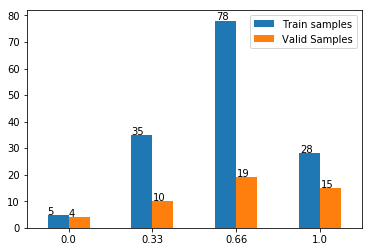

In [5]:
# import pandas as pd
ypredict, yscores = get_predictions(verbose=0)
eg_level, train_cnt = np.unique(yscores['Train'], return_counts=True)
eg_level, val_cnt = np.unique(yscores['Valid'], return_counts=True)
df = pd.DataFrame({'Train samples':train_cnt, 'Valid Samples': val_cnt}, index=eg_level)
ax = df.plot.bar(rot=0)
n_trains = np.sum(train_cnt)
n_vals = np.sum(val_cnt)
print('Num train {}, val {}'.format(n_trains, n_vals))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
# print(67*4/48)

### Submission 01 
```
Average 3 model
```
- Overall Mean Square Error: **0.078661**  
- Mean Square Error for Engagement level 0: 0.334221  
- Mean Square Error for Engagement level 1: 0.083368  
- Mean Square Error for Engagement level 2: 0.013338  
- Mean Square Error for Engagement level 3: 0.066046

In [6]:
def submission_01_ck():
    ypredict, yscores = get_predictions()
    ld_cfg = cfg.md_cfg
    # Submission 01, average of model 0, 1, 2
    md_index = [0, 1, 2]
    ypredict_avg_fn, train_mse, val_mse = avg_ensemble(copy.deepcopy(ypredict), copy.deepcopy(yscores), md_index = [0, 1, 2],
                                                           write_path=None)
    
    # Write submission to files
    write_txt(yscores['Test'], ypredict_avg_fn['Test'], txt_path='./submission_01/')
    # Load submission 01 to check
    yx = []
    yx_names = []
    ldx = os.listdir('./submission_01/')
    for idx in range(len(ldx)):
        current_name = ldx[idx]
        if current_name.endswith('.txt'):
            with open('submission_01/' + current_name, 'r') as f:
                yx.append(float(f.readline()))
                yx_names.append(current_name[:-4])
                
    ck_names = np.array([yx_names, yscores['Test']]).T
    ck_values = np.array([yx, ypredict_avg_fn['Test']]).T
    
    ckn = np.count_nonzero(ck_names[:, 0] != ck_names[:, 1])
    ckv = np.count_nonzero(ck_values[:, 0] != ck_values[:, 1])
    if ckn == 0 and ckv == 0:
        print("Exact ^^. Completed.")
    else:
        print('Failed, please check again.')
    
    return ypredict_avg_fn

_ = submission_01_ck()

Number of models to be average: 3
Train:
Min -0.005037905027469. Max 0.9521716237068176. MSE 0.0046861650825803115
Valid:
Min 0.3349830359220505. Max 0.8595088322957356. MSE 0.049722080986325856
Test:
Min 0.25669900079568225. Max 0.8801403840382893
Exact ^^. Completed.


### Submission 02
```SVM ensemble 4 models```
- Overall Mean Square Error: **0.091114** 
- Mean Square Error for Engagement level 0: 0.328931 
- Mean Square Error for Engagement level 1: 0.108693 
- Mean Square Error for Engagement level 2: 0.027030 
- Mean Square Error for Engagement level 3: 0.035344

In [7]:
def submission_02_ck():
    ypredict, yscores = get_predictions()
    ld_cfg = cfg.md_cfg
    svm_exper_key = '3c4e56dd6f8a4fb7b76d6f7d970e48a2'  # 
    
    # Submission 02, SVM of 0, 1, 2, 3
    ypredict['Train'] = ypredict['Train'].T
    ypredict['Valid'] = ypredict['Valid'].T
    ypredict['Test'] = ypredict['Test'].T

    scaler = joblib.load('./sklearn_model/{}_sc.pkl'.format(svm_exper_key))
    clf = joblib.load('./sklearn_model/{}_clf.pkl'.format(svm_exper_key))

    ypredict_svm_fn, train_svm_mse, val_svm_mse = clf_predict(ypredict, yscores, clf, scaler, svm_experiment=None, write_path=None, verbose=0)
            
    # Write submission to files
    write_txt(yscores['Test'], ypredict_svm_fn['Test'], txt_path='./submission_02/')
    
    # Load submission 02 to check
    yx = []
    yx_names = []
    ldx = os.listdir('./submission_02/')
    for idx in range(len(ldx)):
        current_name = ldx[idx]
        if current_name.endswith('.txt'):
            with open('submission_02/' + current_name, 'r') as f:
                yx.append(float(f.readline()))
                yx_names.append(current_name[:-4])
            
    ck_names = np.array([yx_names, yscores['Test']]).T
    ck_values = np.array([yx, ypredict_svm_fn['Test']]).T
    
    ckn = np.count_nonzero(ck_names[:, 0] != ck_names[:, 1])
    ckv = np.count_nonzero(ck_values[:, 0] != ck_values[:, 1])
    if ckn == 0 and ckv == 0:
        print("Exact ^^. Completed.")
    else:
        print('Failed, please check again.') 
    
    return ypredict_svm_fn

_ = submission_02_ck()

Train
Train. Min 0.127007890896647. Max 0.9427618711407286. MSE 0.008219488234086704
Valid
Valid. Min 0.19037981562931455. Max 0.9173414134357303. MSE 0.03723437079793676
Test
Test. Min 0.1632684008307948. Max 0.9245766071797195
Exact ^^. Completed.


### Submission 03
```Average 2 models```
- Overall Mean Square Error: **0.069625** 
- Mean Square Error for Engagement level 0: 0.268581 
- Mean Square Error for Engagement level 1: 0.064421 
- Mean Square Error for Engagement level 2: 0.023098 
- Mean Square Error for Engagement level 3: 0.064037 

In [8]:
def submission_03_ck():
    ypredict, yscores = get_predictions()
    ld_cfg = cfg.md_cfg
    # Submission 01, average of model 0, 2
    md_index = [0, 2]
    ypredict_avg_fn, train_mse, val_mse = avg_ensemble(copy.deepcopy(ypredict), copy.deepcopy(yscores), md_index = md_index,
                                                           write_path=None)
    
    # Write submission to files
    write_txt(yscores['Test'], ypredict_avg_fn['Test'], txt_path='./submission_03/')
    # Load submission 03 to check
    yx = []
    yx_names = []
    ldx = os.listdir('./submission_03/')
    for idx in range(len(ldx)):
        current_name = ldx[idx]
        if current_name.endswith('.txt'):
            with open('submission_03/' + current_name, 'r') as f:
                yx.append(float(f.readline()))
                yx_names.append(current_name[:-4])
            
    ck_names = np.array([yx_names, yscores['Test']]).T
    ck_values = np.array([yx, ypredict_avg_fn['Test']]).T
    
    ckn = np.count_nonzero(ck_names[:, 0] != ck_names[:, 1])
    ckv = np.count_nonzero(ck_values[:, 0] != ck_values[:, 1])
    if ckn == 0 and ckv == 0:
        print("Exact ^^. Completed.")
    else:
        print('Failed, please check again.')  
    
    return ypredict_avg_fn
_ = submission_03_ck()

Number of models to be average: 2
Train:
Min -0.03020166844362393. Max 0.9489489793777466. MSE 0.005174875540833624
Valid:
Min 0.2734040692448616. Max 0.8653900027275085. MSE 0.051754981281858514
Test:
Min 0.20518453419208527. Max 0.8657699525356293
Exact ^^. Completed.
